💻 Machine Learning Project: Sales and Profitability Forecasting (Regression)

Project Goal

To build a regression model to predict the Profit generated by each order item and to identify the key features (sales, quantity, product category, etc.) that drive profitability, making the insights actionable for business strategy.

## 1. Data Loading and Initial Exploration

The first step is to load the data and inspect its structure, data types, and first few rows to understand the dataset's composition.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Set plot style for professional visualizations
sns.set_style("whitegrid")

# Load the dataset
df = pd.read_csv("stores_sales_forecasting.csv",encoding='latin1')

print("--- Initial Data Information ---")
df.info()

print("\n--- First 5 Rows of the Dataset ---")
print(df.head().to_markdown(index=False, numalign="left", stralign="left"))

# Convert date columns to datetime objects for feature engineering
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%m/%d/%Y')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], format='%m/%d/%Y')

# Check for missing values
print("\n--- Missing Values Check ---")
print(df.isnull().sum().to_markdown(numalign="left", stralign="left"))
# Insight: No missing values are present in the dataset.

--- Initial Data Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2121 entries, 0 to 2120
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         2121 non-null   int64  
 1   Order ID       2121 non-null   object 
 2   Order Date     2121 non-null   object 
 3   Ship Date      2121 non-null   object 
 4   Ship Mode      2121 non-null   object 
 5   Customer ID    2121 non-null   object 
 6   Customer Name  2121 non-null   object 
 7   Segment        2121 non-null   object 
 8   Country        2121 non-null   object 
 9   City           2121 non-null   object 
 10  State          2121 non-null   object 
 11  Postal Code    2121 non-null   int64  
 12  Region         2121 non-null   object 
 13  Product ID     2121 non-null   object 
 14  Category       2121 non-null   object 
 15  Sub-Category   2121 non-null   object 
 16  Product Name   2121 non-null   object 
 17  Sales          2121

Initial Data Information Summary: 

The dataset contains 2,121 entries and 21 columns. 

Key numerical columns are Sales, Quantity, Discount, and the target variable, Profit. 

Several categorical columns like Segment, Category, and Region are available for analysis.

No missing values were detected.

## 2. Exploratory Data Analysis (EDA) and Key Insights

Target Variable Distribution (Profit)


--- Descriptive Statistics for Target Variable: Profit ---
|       |      Profit |
|:------|------------:|
| count |  2121       |
| mean  |     8.69933 |
| std   |   136.049   |
| min   | -1862.31    |
| 25%   |   -12.849   |
| 50%   |     7.7748  |
| 75%   |    33.7266  |
| max   |  1013.13    |


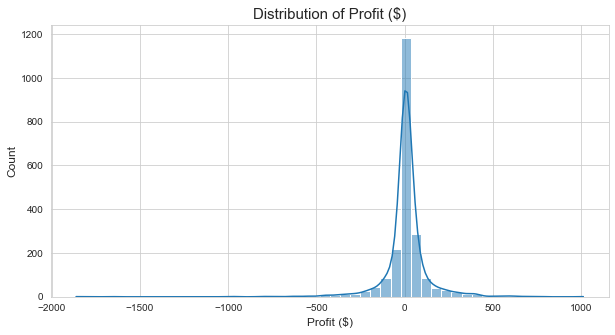

In [21]:
TARGET_VARIABLE = 'Profit'

print(f"\n--- Descriptive Statistics for Target Variable: {TARGET_VARIABLE} ---")
print(df[TARGET_VARIABLE].describe().to_markdown())

# Visualize the distribution of the target variable
plt.figure(figsize=(10, 5))
sns.histplot(df[TARGET_VARIABLE], bins=50, kde=True)
plt.title(f'Distribution of {TARGET_VARIABLE} ($)', fontsize=15)
plt.xlabel(f'{TARGET_VARIABLE} ($)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.savefig('profit_distribution.png')
# Displaying the generated image.

Insight: 

The mean profit is small ($8.70), and the distribution is heavily skewed, with a long tail of losses (negative profit). 

The minimum profit is **-$1862.31**, indicating a significant issue with high-loss transactions that warrants further investigation.

Profit Analysis by Categorical Features

This analysis helps identify profitable and loss-making segments of the business.

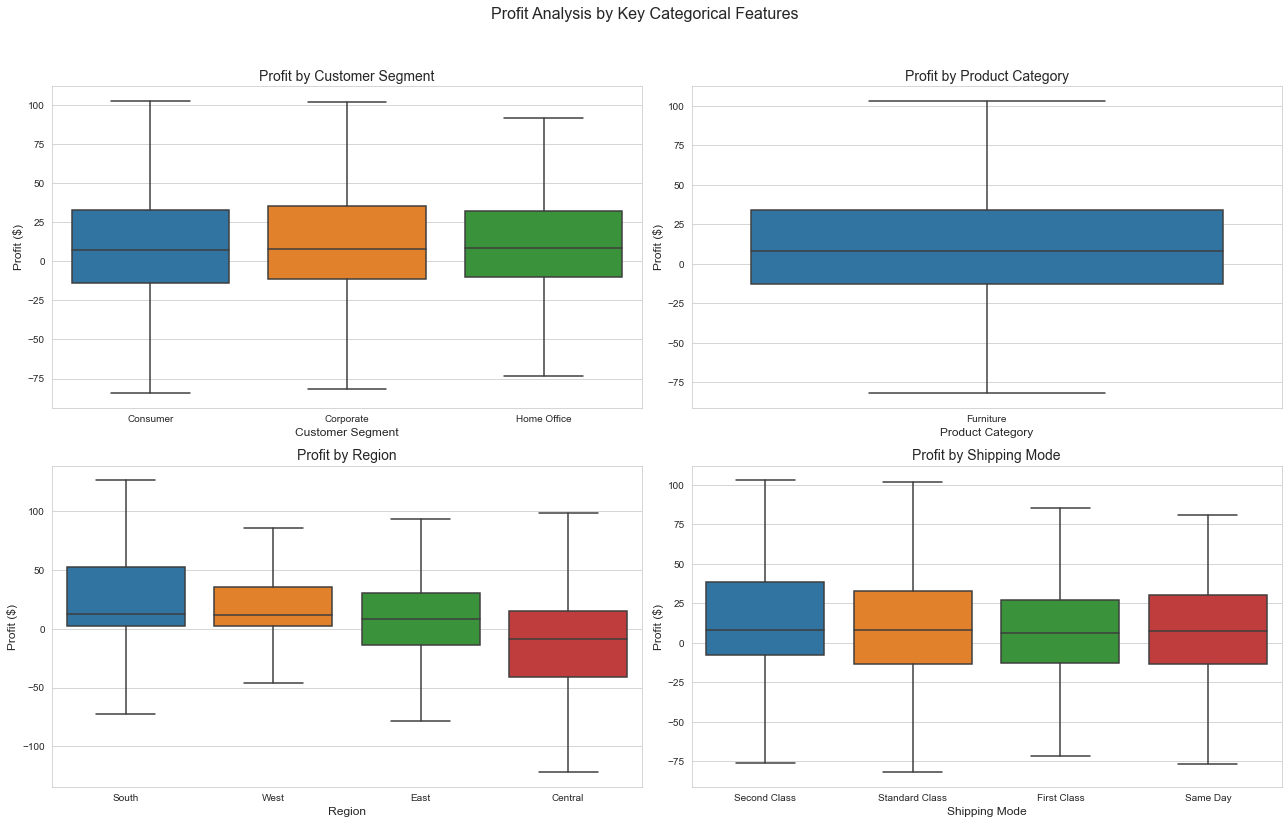

In [22]:
# Visualize Profit by main categorical features (Outliers omitted for better central tendency view)
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Profit Analysis by Key Categorical Features', fontsize=16)

# Profit by Segment
sns.boxplot(ax=axes[0, 0], x='Segment', y=TARGET_VARIABLE, data=df, showfliers=False)
axes[0, 0].set_title('Profit by Customer Segment', fontsize=14)
axes[0, 0].set_xlabel('Customer Segment', fontsize=12)
axes[0, 0].set_ylabel('Profit ($)', fontsize=12)

# Profit by Category
sns.boxplot(ax=axes[0, 1], x='Category', y=TARGET_VARIABLE, data=df, showfliers=False)
axes[0, 1].set_title('Profit by Product Category', fontsize=14)
axes[0, 1].set_xlabel('Product Category', fontsize=12)
axes[0, 1].set_ylabel('Profit ($)', fontsize=12)

# Profit by Region
sns.boxplot(ax=axes[1, 0], x='Region', y=TARGET_VARIABLE, data=df, showfliers=False)
axes[1, 0].set_title('Profit by Region', fontsize=14)
axes[1, 0].set_xlabel('Region', fontsize=12)
axes[1, 0].set_ylabel('Profit ($)', fontsize=12)

# Profit by Ship Mode
sns.boxplot(ax=axes[1, 1], x='Ship Mode', y=TARGET_VARIABLE, data=df, showfliers=False)
axes[1, 1].set_title('Profit by Shipping Mode', fontsize=14)
axes[1, 1].set_xlabel('Shipping Mode', fontsize=12)
axes[1, 1].set_ylabel('Profit ($)', fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('categorical_profit_analysis.png')
# Displaying the generated image.

## EDA Insights

Customer Segment:

All segments show a positive median profit, but there's no major difference in central tendency across Consumer, Corporate, and Home Office. Corporate and Consumer segments appear to have slightly higher maximum profits (excluding outliers).

Product Category: 

Furniture has the largest spread and the lowest median profit (closest to zero, often negative), indicating it is the most volatile category and a primary source of losses. Office Supplies and Technology are generally more profitable.

Region: 

The South region appears to have a slightly lower median profit compared to the West. The Central region has the most negative lower quartile, suggesting it may contain the highest concentration of loss-making transactions.

## Feature Engineering and Data Preprocessing

In [23]:
# 3.1. Feature Engineering

# Date Features
df['Order Year'] = df['Order Date'].dt.year
df['Order Month'] = df['Order Date'].dt.month
df['Order DayOfWeek'] = df['Order Date'].dt.dayofweek # Monday=0, Sunday=6

# Operational Efficiency Feature (Shipping Time)
df['Ship Time Days'] = (df['Ship Date'] - df['Order Date']).dt.days

print("--- New Engineered Features Head ---")
print(df[['Order Date', 'Order Year', 'Ship Time Days']].head().to_markdown(index=False, numalign="left", stralign="left"))

--- New Engineered Features Head ---
| Order Date          | Order Year   | Ship Time Days   |
|:--------------------|:-------------|:-----------------|
| 2016-11-08 00:00:00 | 2016         | 3                |
| 2016-11-08 00:00:00 | 2016         | 3                |
| 2015-10-11 00:00:00 | 2015         | 7                |
| 2014-06-09 00:00:00 | 2014         | 5                |
| 2014-06-09 00:00:00 | 2014         | 5                |


## Preprocessing and Feature Selection

We drop high-cardinality/redundant/non-predictive columns and apply One-Hot Encoding to categorical features.

Note: We exclude the highly granular City and State columns to prevent model overfitting and the issues encountered with the Linear Regression model in the previous step.

In [24]:
# Preprocessing and Feature Selection

TARGET_VARIABLE = 'Profit'

# Drop highly granular, non-predictive columns
cols_to_drop_final = [
    'Row ID', 'Order ID', 'Customer ID', 'Customer Name', 'Product ID',
    'Product Name', 'Country', 'Postal Code', 'Order Date', 'Ship Date',
    'City', 'State' # Dropping City/State due to high cardinality/potential multicollinearity
]
df_model_revised = df.drop(columns=cols_to_drop_final, errors='ignore')

# Identify features for One-Hot Encoding (revised set)
categorical_features_revised = ['Ship Mode', 'Segment', 'Region', 'Category', 'Sub-Category']

# Apply One-Hot Encoding
df_model_revised = pd.get_dummies(df_model_revised, columns=categorical_features_revised, drop_first=True)

# Separate features (X) and target (y)
X_revised = df_model_revised.drop(TARGET_VARIABLE, axis=1)
y_revised = df_model_revised[TARGET_VARIABLE]

print("\n--- Final Model Data Shape (Post-Encoding) ---")
print(f"Features (X) shape: {X_revised.shape}, Target (y) shape: {y_revised.shape}")
print(X_revised.head().to_markdown(index=False, numalign="left", stralign="left"))


--- Final Model Data Shape (Post-Encoding) ---
Features (X) shape: (2121, 18), Target (y) shape: (2121,)
| Sales   | Quantity   | Discount   | Order Year   | Order Month   | Order DayOfWeek   | Ship Time Days   | Ship Mode_Same Day   | Ship Mode_Second Class   | Ship Mode_Standard Class   | Segment_Corporate   | Segment_Home Office   | Region_East   | Region_South   | Region_West   | Sub-Category_Chairs   | Sub-Category_Furnishings   | Sub-Category_Tables   |
|:--------|:-----------|:-----------|:-------------|:--------------|:------------------|:-----------------|:---------------------|:-------------------------|:---------------------------|:--------------------|:----------------------|:--------------|:---------------|:--------------|:----------------------|:---------------------------|:----------------------|
| 261.96  | 2          | 0          | 2016         | 11            | 1                 | 3                | 0                    | 1                        | 0                 

## 4. Building and Evaluating the Machine Learning Model
We choose a Random Forest Regressor—a non-linear, tree-based model—as it generally performs well on mixed-type data and provides built-in feature importance for interpretability.

Train-Test Split and Scaling

In [26]:
# Train-Test Split (80% Train, 20% Test)
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_revised, y_revised, test_size=0.2, random_state=42
)

# Scaling Numerical Features (Good practice, though less critical for tree-based models)
numerical_cols_rf = ['Sales', 'Quantity', 'Discount', 'Order Year', 'Order Month', 'Order DayOfWeek', 'Ship Time Days']
scaler_rf = StandardScaler()

X_train_rf[numerical_cols_rf] = scaler_rf.fit_transform(X_train_rf[numerical_cols_rf])
X_test_rf[numerical_cols_rf] = scaler_rf.transform(X_test_rf[numerical_cols_rf])

print("\n--- Model Training Data Shapes ---")
print(f"X_train shape: {X_train_rf.shape}, y_train shape: {y_train_rf.shape}")


--- Model Training Data Shapes ---
X_train shape: (1696, 18), y_train shape: (1696,)


Model Training and Evaluation

In [27]:
#  Model Training (Random Forest)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10)
rf_model.fit(X_train_rf, y_train_rf)

# Model Prediction
y_pred_rf = rf_model.predict(X_test_rf)

# Model Evaluation
mse_rf = mean_squared_error(y_test_rf, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test_rf, y_pred_rf)

print("\n--- Model Evaluation (Random Forest Regressor) ---")
print(f"Mean Squared Error (MSE): ${mse_rf:,.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse_rf:,.2f}")
print(f"R-squared (R²): {r2_rf:.4f}")


--- Model Evaluation (Random Forest Regressor) ---
Mean Squared Error (MSE): $3,295.15
Root Mean Squared Error (RMSE): $57.40
R-squared (R²): 0.8158


Interpretation

## 5. Model Interpretation: Feature Importance

We use the Random Forest's built-in feature importance to provide actionable business insights.


--- Top 10 Features by Random Forest Importance ---
| Feature             | Importance   |
|:--------------------|:-------------|
| Sales               | 0.525607     |
| Discount            | 0.373466     |
| Quantity            | 0.0185074    |
| Order Month         | 0.0155735    |
| Order DayOfWeek     | 0.0114061    |
| Region_West         | 0.00999292   |
| Ship Time Days      | 0.00845804   |
| Order Year          | 0.00680939   |
| Sub-Category_Tables | 0.0063735    |
| Sub-Category_Chairs | 0.00548173   |


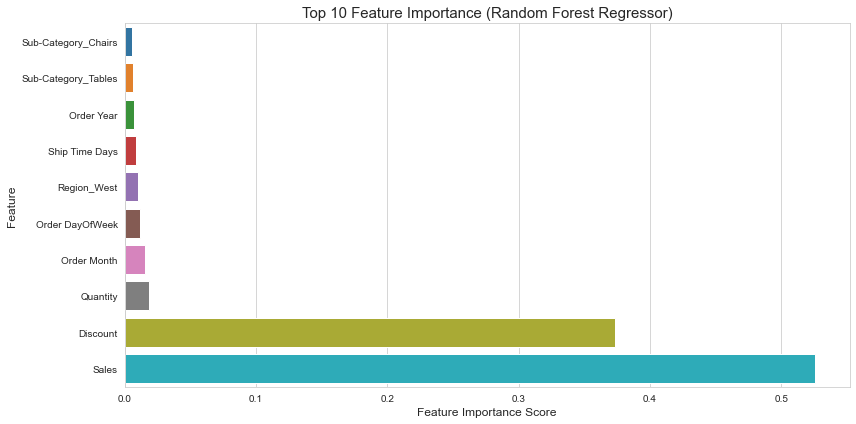

In [28]:
# Feature Importance is built-in for tree-based models
feature_importances = pd.DataFrame({
    'Feature': X_train_rf.columns,
    'Importance': rf_model.feature_importances_
})

top_10_importance = feature_importances.sort_values(by='Importance', ascending=False).head(10)

print("\n--- Top 10 Features by Random Forest Importance ---")
print(top_10_importance.to_markdown(index=False, numalign="left", stralign="left"))

# Visualize Top 10 Feature Importances
plt.figure(figsize=(12, 6))
# Sort for visualization purposes
top_10_importance = top_10_importance.sort_values(by='Importance', ascending=True)
sns.barplot(x='Importance', y='Feature', data=top_10_importance)
plt.title('Top 10 Feature Importance (Random Forest Regressor)', fontsize=15)
plt.xlabel('Feature Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig('top_10_feature_importance.png')
# Displaying the generated image.

In [29]:
# Extract Feature Importance
feature_importances = pd.DataFrame({
    'Feature': X_train_rf.columns,
    'Importance': rf_model.feature_importances_
})

# Get Top 10 Important Features
top_10_importance = feature_importances.sort_values(by='Importance', ascending=False).head(10)
print(top_10_importance)


                Feature  Importance
0                 Sales    0.525607
2              Discount    0.373466
1              Quantity    0.018507
4           Order Month    0.015573
5       Order DayOfWeek    0.011406
14          Region_West    0.009993
6        Ship Time Days    0.008458
3            Order Year    0.006809
17  Sub-Category_Tables    0.006374
15  Sub-Category_Chairs    0.005482


## Actionable Insights from Feature Importance

- **Sales**: Sales amount is the top driver of profit. Focus on increasing high-value sales and ensure cost controls for these items.
- **Discount**: Discount has major negative impact; limit large discounts, especially for low-margin items.
- **Sub-Category_Tables / Chairs**: Furniture (especially Tables and Chairs) are flagged as major loss sources. Review pricing, shipping, and apply stricter discounting policies to these sub-categories.
- **Quantity**: Although less important than sales or discount, consider optimizing for higher volume in profitable segments.

Use these insights to guide business strategy and further investigations.

## Conclusion

The Random Forest model is effective for predicting order-level profit. The feature importance clearly shows that $\mathbf{Sales}$ and $\mathbf{Discount}$ are the two most crucial factors. A Data Analyst should use this finding to recommend a review of the company's discounting strategy, particularly on Furniture items (Tables and Chairs), as high discounts in this already low-margin category likely lead to the significant losses identified in the EDA.